In [1]:
library("gaston")

Loading required package: Rcpp
Loading required package: RcppParallel

Attaching package: 'RcppParallel'

The following object is masked from 'package:Rcpp':

    LdFlags

Gaston set number of threads to 4. Use setThreadOptions() to modify this.

Attaching package: 'gaston'

The following object is masked from 'package:stats':

    sigma

The following objects are masked from 'package:base':

    cbind, rbind



In [2]:
#sort
geno <-read.table("Hetero_realigned_cov10_filtered3.raw", row.names=1, header=T)
colnames(geno)<-1:3928
rownames(geno)<-1:240
lin_map<-read.table("raw.map")
lin_map["id"]=1:3928
m<-lin_map[order(lin_map$V2),]
sortM<-m[order(m$V1),]
sortgeno<-geno[,sortM$id]
colnames(sortgeno)<-1:3928
pheno <- read.csv("2017heteroPheno.csv", header=T)
attach(pheno)

In [4]:
G<-sortgeno[,!duplicated.matrix(sortgeno,MARGIN = 2)]
fam<-data.frame(famid=rep(NA,length(bcw)), id=1:length(bcw), father=rep(NA,length(bcw)),
                mother=rep(NA,length(bcw)), sex=rep(NA,length(bcw)),pheno=bcw)
bim<-data.frame(chr=sortM$V1[!duplicated.matrix(sortgeno,MARGIN = 2)], id=1:length(G), dist=rep(NA,length(G)),
                pos=sortM$V2[!duplicated.matrix(sortgeno,MARGIN = 2)], A1=rep(NA,length(G)),A2=rep(NA,length(G)))
x<-as.bed.matrix(as.matrix(G), fam, bim)

In [7]:
standardize(x)<-"mu"
ld<-LD(x,c(1,length(G)), measure = c("r2"),trim = TRUE)
#ld[is.na(ld)] <- 1

In [44]:
ld.pair<-list()
for (i in 1:(length(G)-1)){
    ld.pair[i]<-ld[i,i+1]
}

In [45]:
summary(as.numeric(ld.pair))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
0.000000 0.001971 0.009195 0.092721 0.043879 0.986220        2 

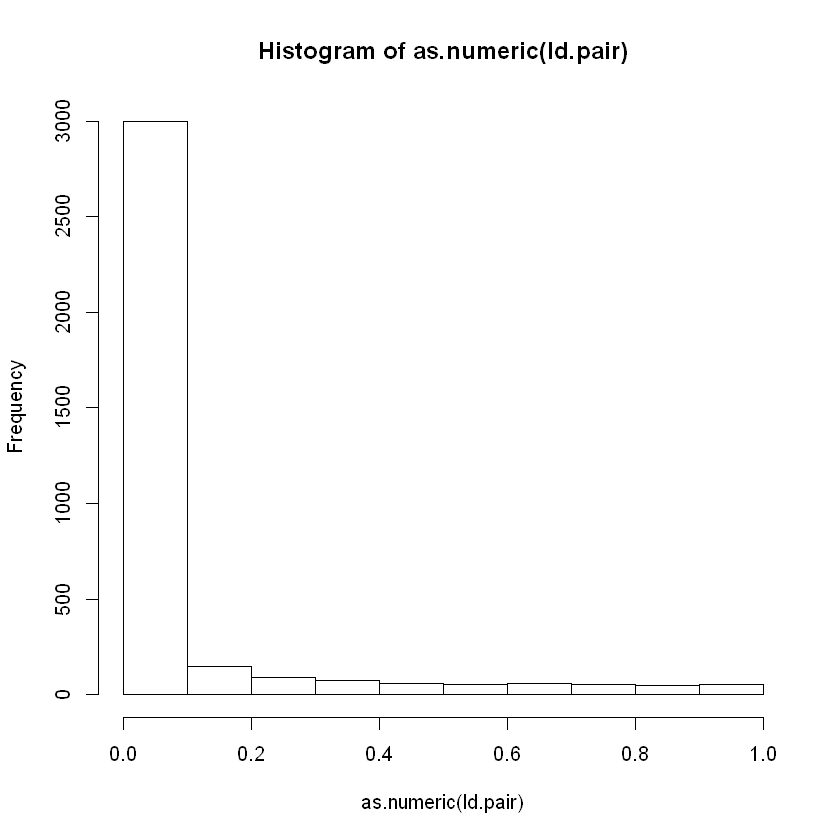

In [46]:
hist(as.numeric(ld.pair))

In [6]:
k1<-GRM(x)

In [7]:
estimates <- lmm.aireml(bcw, K = k1, verbose = FALSE) 
str(estimates)


List of 11
 $ sigma2    : num 54.7
 $ tau       : num 70.7
 $ logL      : num -646
 $ logL0     : num -652
 $ niter     : int 5
 $ norm_grad : num 4.97e-06
 $ Py        : num [1:240] 0.1285 0.0226 0.0376 -0.1722 0.0841 ...
 $ BLUP_omega: num [1:240] 4.1179 -0.0873 0.0911 -2.4387 -3.4525 ...
 $ BLUP_beta : num 15.9
 $ varbeta   : num [1, 1] 0.228
 $ varXbeta  : num -3.04e-13


In [16]:
cor(estimates$BLUP_beta+estimates$tau * t(k1) %*% estimates$Py,bcw)

0.8859145


In [41]:
library("rrBLUP")

In [45]:
K1 <- A.mat(as.matrix(sortgeno[,1:300]))
K2 <- A.mat(as.matrix(sortgeno[,301:3928]))
estimates <-  lmm.aireml(bcw,  K = list(K1, K2), verbose = FALSE) 
str(estimates)

List of 10
 $ sigma2    : num 47.5
 $ tau       : num [1:2] 15.4 38.1
 $ logL      : num -644
 $ logL0     : num -652
 $ niter     : int 6
 $ norm_grad : num 2.56e-06
 $ Py        : num [1:240] 0.1122 0.0189 0.0637 -0.1582 0.0834 ...
 $ BLUP_omega: num [1:240] 5.81 0.249 -0.881 -4.334 -2.818 ...
 $ BLUP_beta : num 15.9
 $ varXbeta  : num -1.52e-13


In [46]:
estimates$tau[1]/(estimates$tau[1]+estimates$tau[2]+estimates$sigma2)

[1] 0.1521443

In [8]:
 set.seed(1) 
n <- 100 
q1 <- 20 
Z1 <- matrix( rnorm(n*q1), nrow = n ) 
X <- cbind(1, 5*runif(n))
u1 <- rnorm(q1, sd = sqrt(2)) 
y <- X %*% c(1,2) + Z1 %*% u1 + rnorm(n, sd = sqrt(3))
q2 <- 10 
Z2 <- matrix( rnorm(n*q2), nrow = n ) 
u2 <- rnorm(q2, sd = 1) 
y2 <- X %*% c(1,2) + Z1 %*% u1 + Z2 %*% u2 + rnorm(n, sd = sqrt(3))


In [9]:
K1 <- tcrossprod(Z1) 
fit <- lmm.aireml(y, X, K = K1, verbose = FALSE)  
str(fit) 

List of 11
 $ sigma2    : num 3.23
 $ tau       : num 1.65
 $ logL      : num -150
 $ logL0     : num -231
 $ niter     : int 12
 $ norm_grad : num 1.29e-08
 $ Py        : num [1:100] 0.531 -0.243 0.116 0.34 -0.304 ...
 $ BLUP_omega: num [1:100] -0.443 -12.628 -1.73 5.059 5.836 ...
 $ BLUP_beta : num [1:2] 1.4 1.79
 $ varbeta   : num [1:2, 1:2] 0.134 -0.0387 -0.0387 0.016
 $ varXbeta  : num 7.6


In [10]:
K2 <- tcrossprod(Z2) 
fit2 <- lmm.aireml(y2, X, K = list(K1, K2), verbose = FALSE) 
str(fit2)

List of 10
 $ sigma2    : num 3.04
 $ tau       : num [1:2] 1.81 0.821
 $ logL      : num -164
 $ logL0     : num -244
 $ niter     : int 13
 $ norm_grad : num 3.02e-07
 $ Py        : num [1:100] -0.353 -0.199 0.879 0.472 0.968 ...
 $ BLUP_omega: num [1:100] 0.342 -15.406 6.239 4.559 4.361 ...
 $ BLUP_beta : num [1:2] 1.1 1.98
 $ varXbeta  : num 9.33


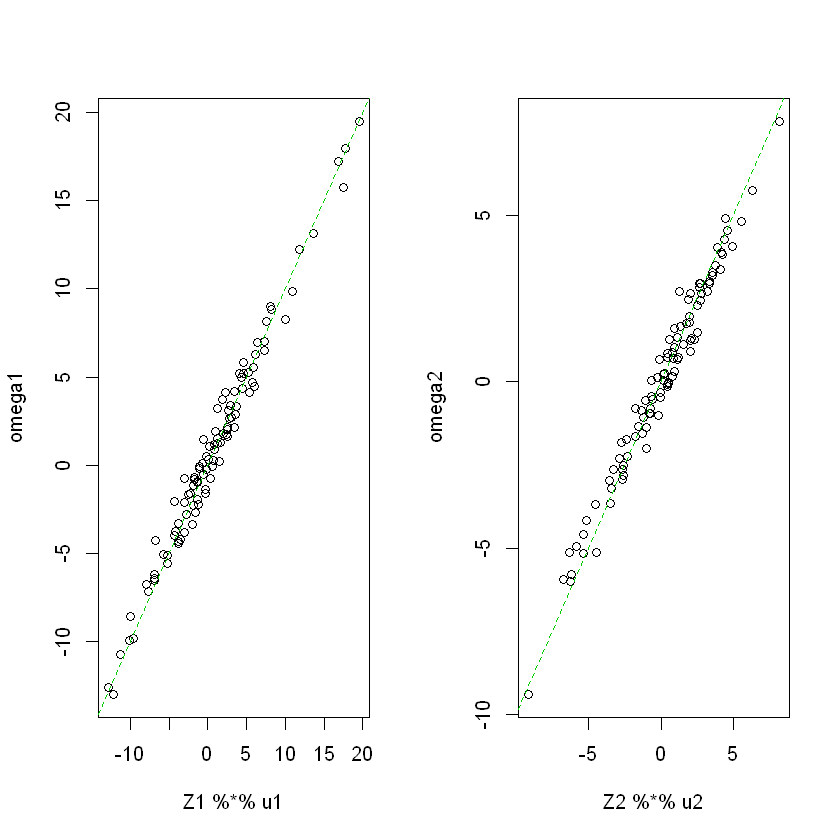

In [11]:
par(mfrow = c(1, 2)) 
omega1 <- fit2$tau[1] * K1 %*% fit2$Py 
omega2 <- fit2$tau[2] * K2 %*% fit2$Py 
plot(Z1 %*% u1, omega1); abline(0, 1, lty = 2, col = 3) 
plot(Z2 %*% u2, omega2); abline(0, 1, lty = 2, col = 3)
